# Postprocessing: data quality check using the analysis
In this notebook we explain how the analysis itself can be used to get an indication of the data quality.

In [2]:
using DIVAnd
using Makie, CairoMakie, GeoMakie
using Dates
using Statistics
using ColorSchemes
include("../config.jl")

"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

## Data reading
Salinity observations are read from a netCDF file based on the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html).     
The reading is done using `loadobs` function.

In [3]:
varname = "Salinity"
filename = salinityprovencalfile
download_check(salinityprovencalfile, salinityprovencalfileURL)

[ Info: File already downloaded


In [4]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity");

### Topography and grid definition

See the [topography notebook](../2-Preprocessing/06-topography.ipynb) for more details.     
Here the code is just replicated to get topography defining the mask.

In [5]:
dx = dy = 0.05
lonr = 2.5:dx:12.
latr = 41.9:dy:44.6

mask,(pm,pn),(xi,yi) = DIVAnd_rectdom(lonr,latr)

bathname = gebco04file
download_check(gebco04file, gebco04fileURL)

bx,by,b = load_bath(bathname,true,lonr,latr)

mask = falses(size(b,1),size(b,2))
for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
    end
end

[ Info: File already downloaded


### Data selection for example

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth range. Here August data at surface:

In [6]:
sel = (obsdepth .< 1) .& (Dates.month.(obstime) .== 8)

obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsids = obsid[sel];
@show (size(obsval))
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

size(obsval) = (1956,)


[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (DateTime("1910-08-09T00:00:00"), DateTime("2014-08-28T19:36:00"))
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


### Analysis

Analysis parameters have been calibrated in the other notebook example.     
Analysis `fi` using mean data as background.      
Structure `s` is stored for later use.

In [7]:
len=0.5
epsilon2=5.0
fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2);

Plot of the gridded field and the observations.

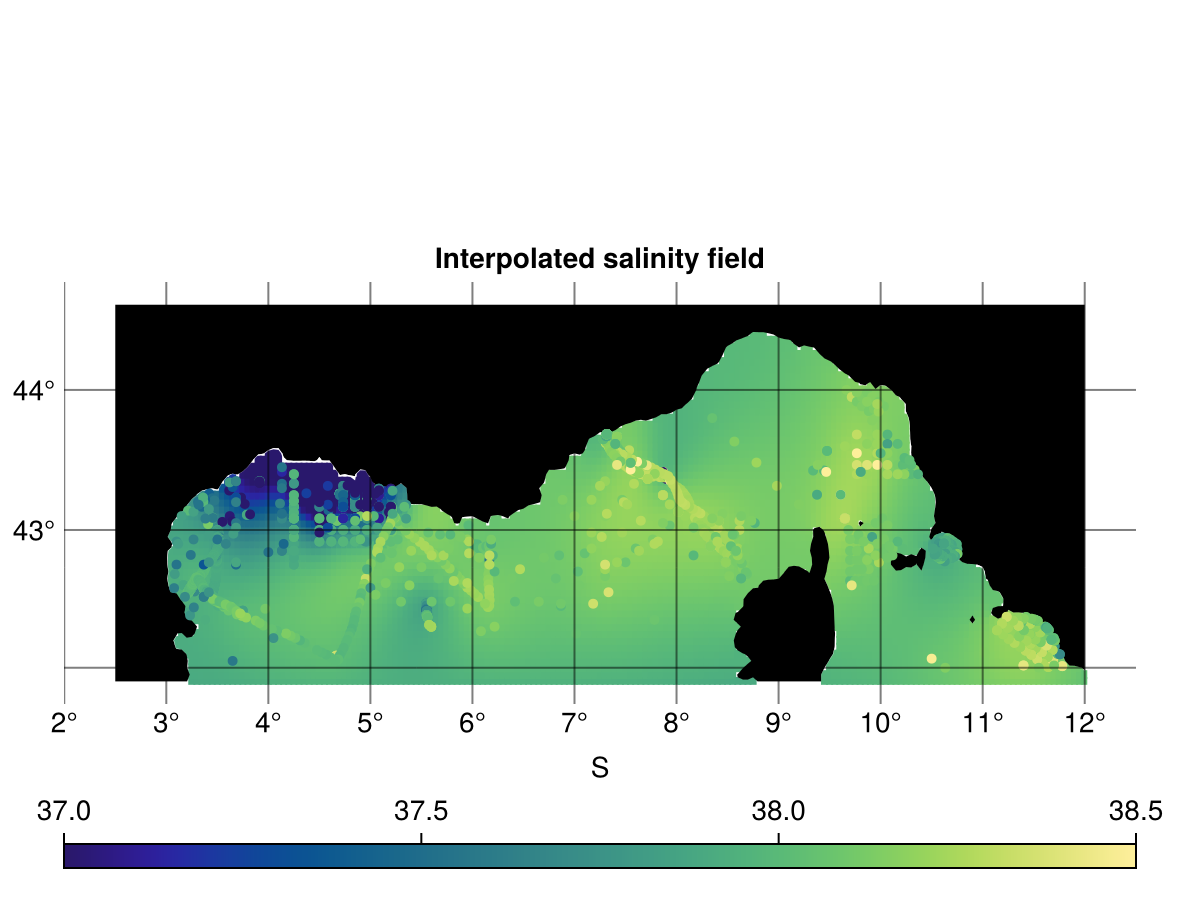

In [8]:
f = Figure()
ax = GeoAxis(f[1,1], title="Interpolated salinity field", dest = "+proj=merc")
hm = heatmap!(ax, lonr, latr, fi.+mean(obsval), colormap=ColorSchemes.haline, 
    colorrange=[37., 38.5], interpolate=false)
Colorbar(f[2,1], hm, vertical = false, label = "S", labelrotation=0)
contourf!(ax, bx, by, b, levels=[-1e5,0, 1.], colormap=Reverse(:binary))
scatter!(ax, obslon, obslat, color=obsval, markersize=7, colormap=ColorSchemes.haline, colorrange=[37., 38.5])
rowgap!(f.layout, -80)
f

Plot of the data residuals

In [8]:
dataresiduals=DIVAnd_residualobs(s,fi)
rscale=sqrt(var(obsval))

0.9951616449902039

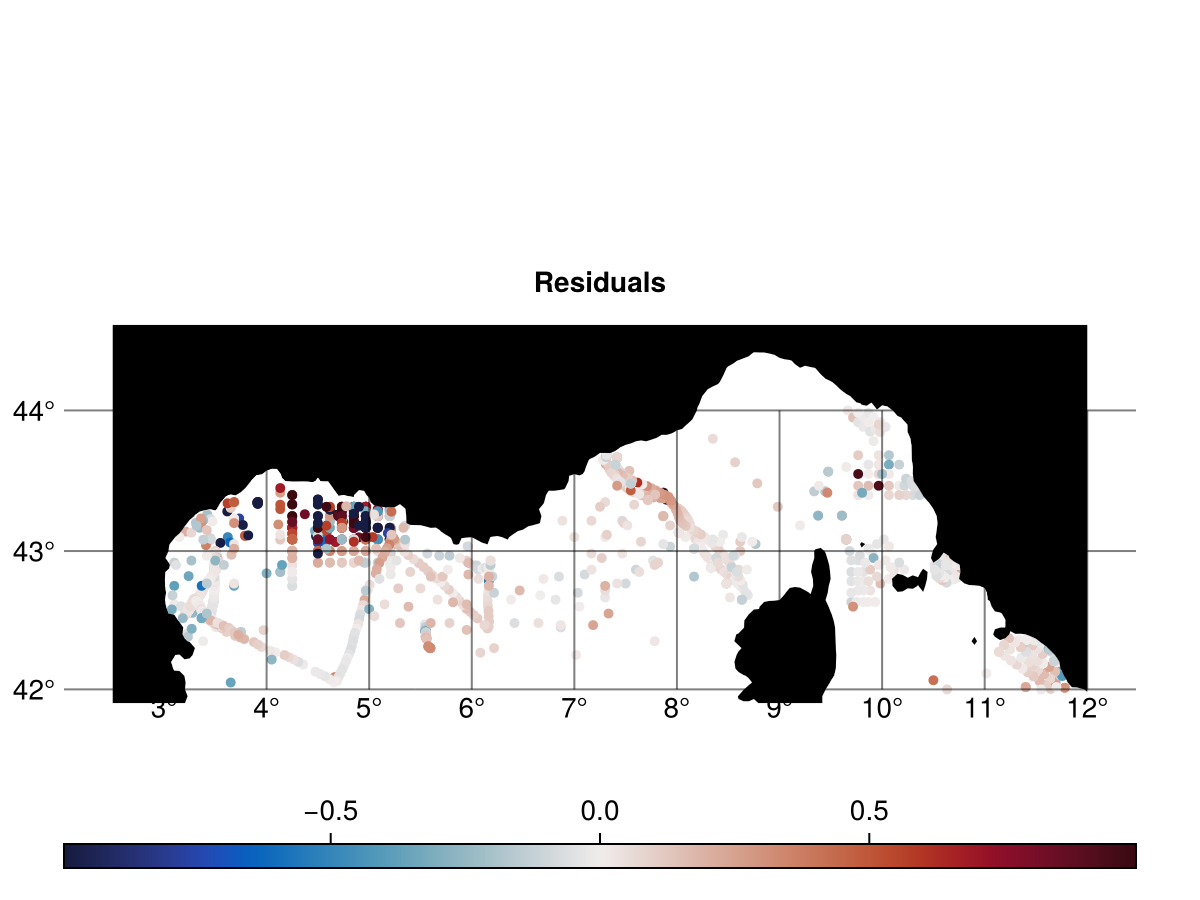

In [9]:
f = Figure()
ax = GeoAxis(f[1,1], title="Residuals", dest = "+proj=merc")
scat = scatter!(ax, obslon, obslat, color=dataresiduals, markersize=7, 
    colormap=ColorSchemes.balance, colorrange=[-rscale, rscale])
Colorbar(f[2,1], scat, vertical = false)
contourf!(ax, bx, by, b, levels=[-1e5,0, 1.], colormap=Reverse(:binary))
rowgap!(f.layout, -80)
f

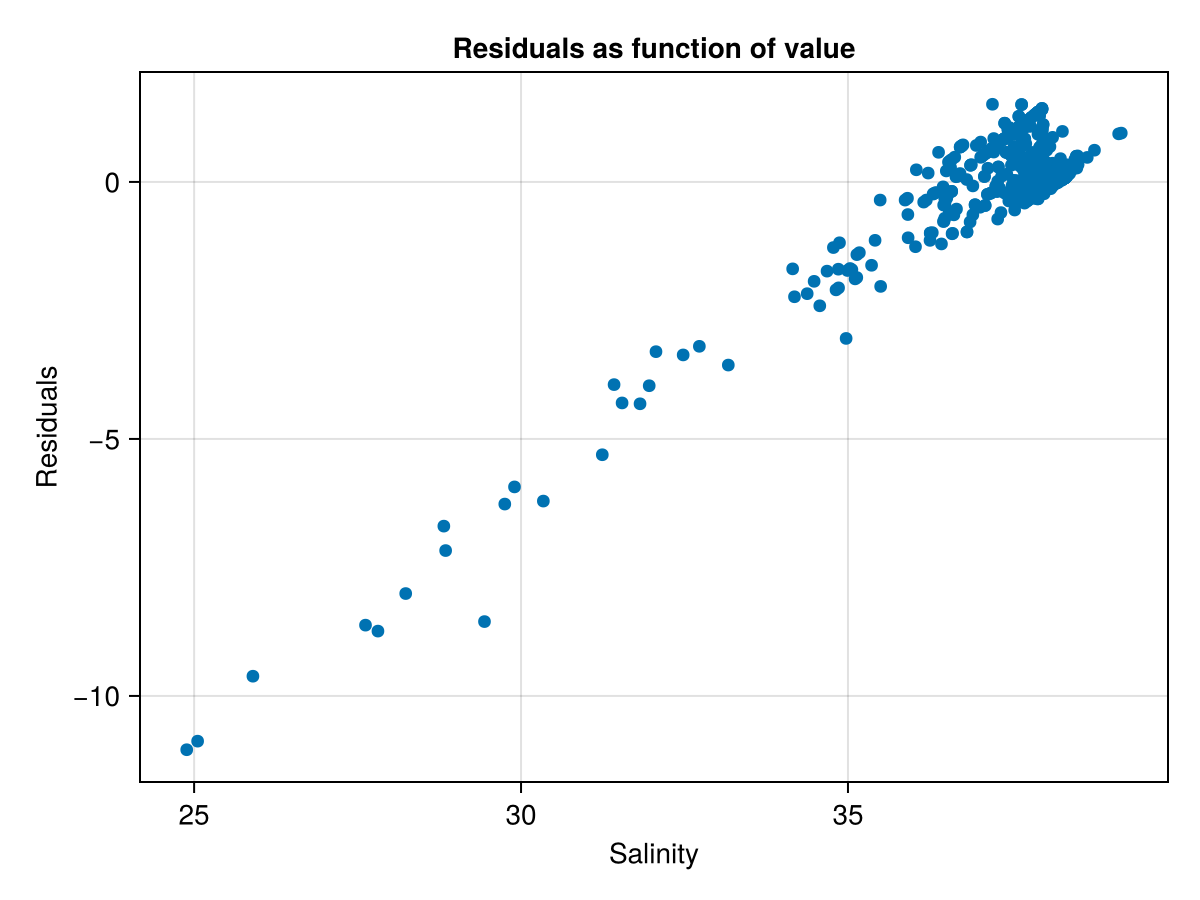

In [10]:
f = Figure()
ax = Axis(f[1,1], title="Residuals as function of value", xlabel="Salinity", ylabel="Residuals")
plot!(ax, obsval,dataresiduals)
f

# Data quality check

As for cross validation, in theory take out data and measure the difference between these data points not used and the analysis. Can be done without actually taking out the points. Three methods are implemented.
## Define method used
The different methods are described as the output of 
```julia
?DIVAnd_qc
```
Here we use the method 1: standard cross validation.    
The suspect data points are considered as those with a QC value higher than 10.

In [11]:
qcval=DIVAnd_qc(fi,s,1)

# Find suspect points
sp=findall(x-> x.>10,qcval)

# Or sort the indicator
suspectindexes=sortperm(qcval,rev=true);

The suspect points are characterised by a lower salinity and are mostly located in the [Rhône estuary](https://en.wikipedia.org/wiki/Rh%C3%B4ne).

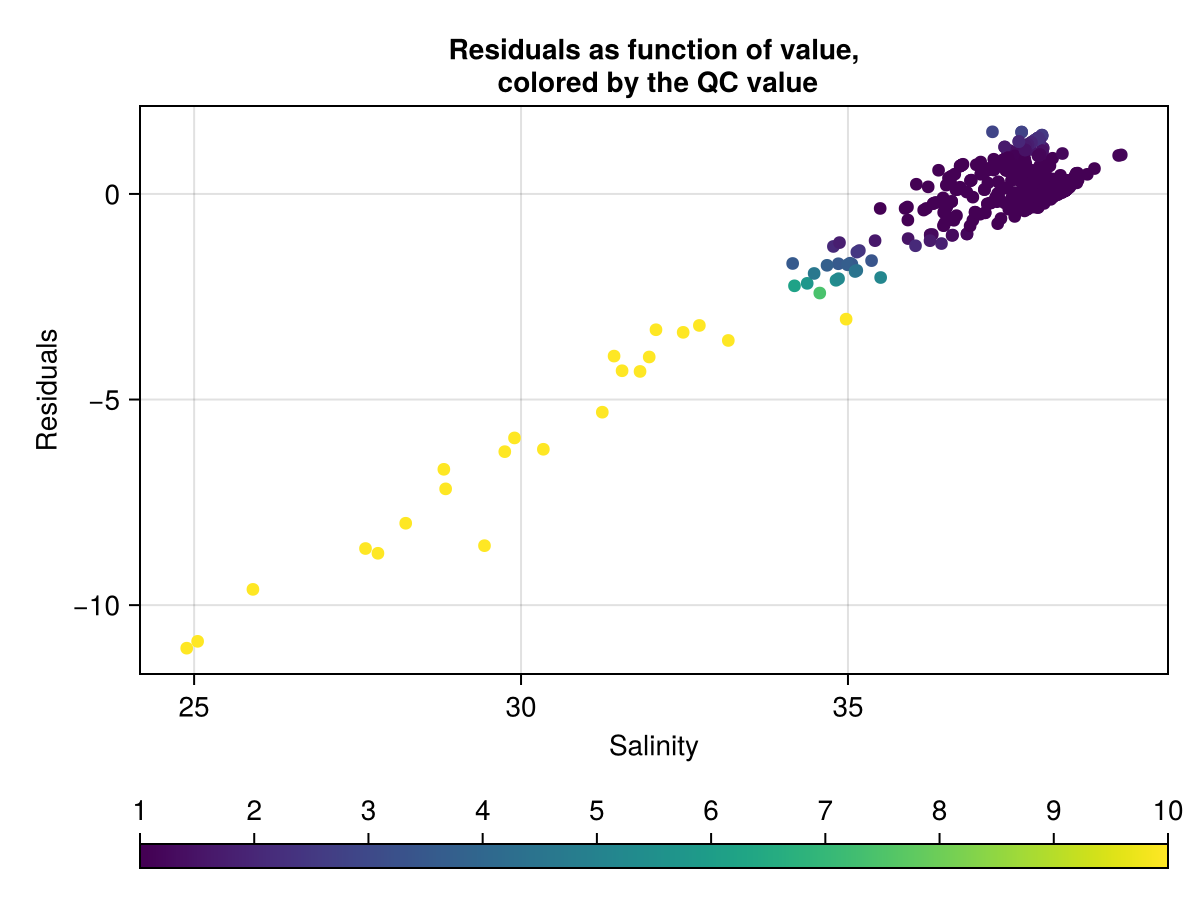

In [12]:
f = Figure()
ax = Axis(f[1,1], title="Residuals as function of value,\n colored by the QC value", xlabel="Salinity", ylabel="Residuals")
scat = scatter!(ax, obsval, dataresiduals, color=qcval, colorrange=[1,10])
Colorbar(f[2,1], scat, vertical = false)
f

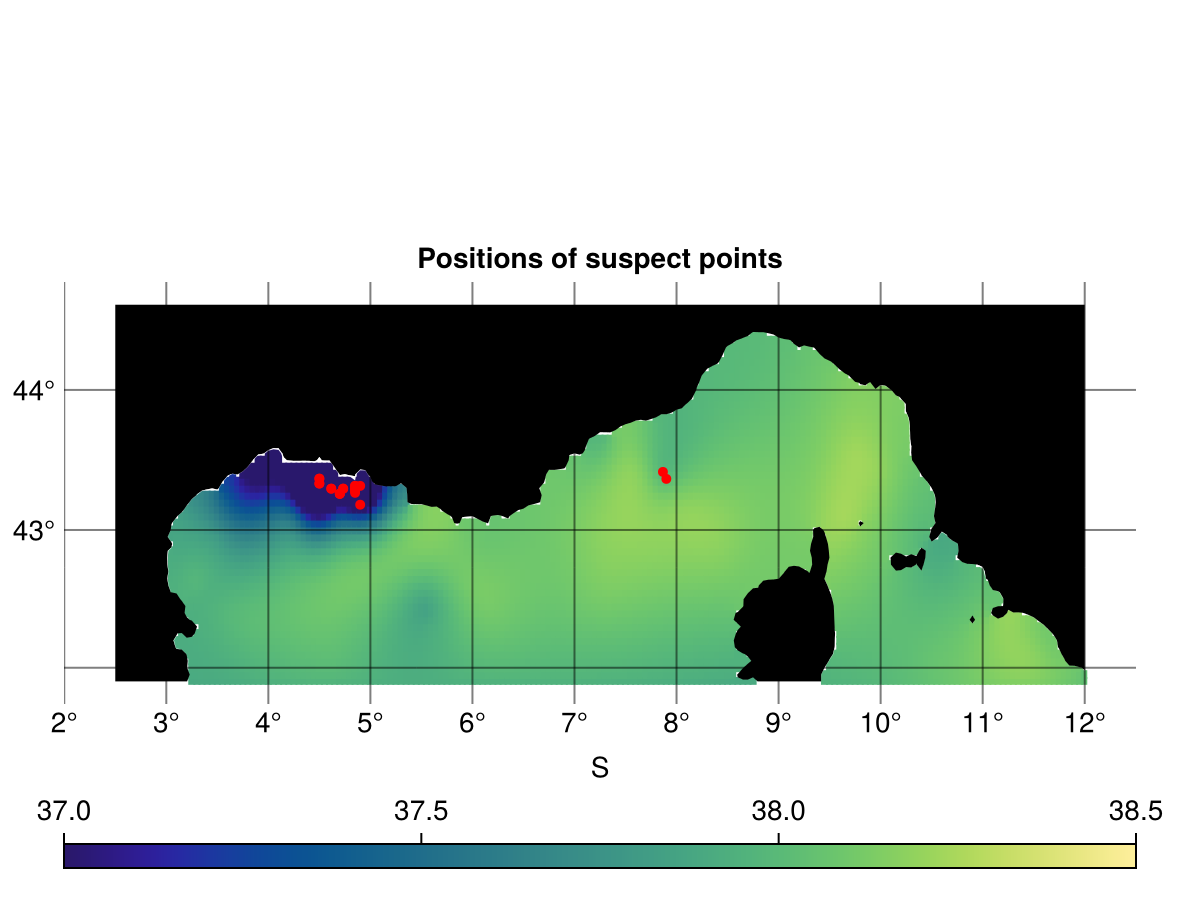

In [13]:
f = Figure()
ax = GeoAxis(f[1,1], title="Positions of suspect points", dest = "+proj=merc")
hm = heatmap!(ax, lonr, latr, fi.+mean(obsval), colormap=ColorSchemes.haline, 
    colorrange=[37., 38.5], interpolate=false)
Colorbar(f[2,1], hm, vertical = false, label = "S", labelrotation=0)
contourf!(ax, bx, by, b, levels=[-1e5,0, 1.], colormap=Reverse(:binary))
plot!(ax, obslon[sp],obslat[sp], color=:red, markersize=7)
rowgap!(f.layout, -80)
f

### More information

In [14]:
?DIVAnd_qc

search: DIVAnd_qc DIVAnd_cv DIVAndgo DIVAndfun DIVAnd DIVAndrun DIVAndjog



```
qcvalues = DIVAnd_qc(fi,s,method);
```

Perform a quality control of the observations using the interpolated field.

# Input:

  * `fi` : interpolated field from a `DIVAndrun` execution
  * `s`: corresponding structure returned by `DIVAnd`
  * `method` : optional argument, which describes the method to be used:

1  as for standard cross validation,  3  as for GCV,  4  with CV estimator to be used outside the routine,  5  Poor man's GCV using data instead of random vector,  0  automatic selection of method.

# Output

  * `qcvalues`: quality check values, one for each data point.

The higher the value, the more suspect a data point is. Absolute values of `qcvalues` might be not robust when analysis parameters are uncertain. The ranking is however quite robust.

If you cannot run `DIVAndrun` but use `DIVAndgo` (which does not provide a structure s at the output), the latter provides `qcvalues` if you call `DIVAndgo` with a keyword parameter `QCMETHOD=`


## Exercise

* Redo for different data.
* Possibly force the cross-validation method (use ?DIVAnd_cv)
* Once opimized, try to redo optimization with starting point being the first estimate+
* Change level for qc parameter used for flagging
* Create non-uniform weights for data using the quality check parameter. Then redo the analysis and possibly the whole chain from analysis, calibration

<div class="alert alert-block alert-warning">
⚠️ Data quality check using analysis-data misfits is usefull but should not replace <b>preprocessing</b> quality checks and proper quality flag exploitation.
</div>